In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/MLEng/Projects/semantic-segmentation-floodnet')

In [3]:
%cd /content/drive/MyDrive/MLEng/Projects/semantic-segmentation-floodnet

/content/drive/MyDrive/MLEng/Projects/semantic-segmentation-floodnet


In [4]:
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 50.4 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=eecf8c16ec06108f3cfec35745676b61bfb517e469f0f449063e6aa461c96fa9
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=0590d39b3a8763f8ff8a825e7c78e31020fdff3dc0938fed410bd14bbb9d0caf
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [63]:
# Image size taken from FloodNet paper for segmentation task
# IMG_SIZE = 713 -- This didn't work for some reason: RuntimeError: Wrong input shape height=713, width=713. Expected image height and width divisible by 8. Consider pad your images to shape (720, 720).
IMG_SIZE = 256

DATA_DIR = '/content/drive/MyDrive/MLEng/Projects/semantic-segmentation-floodnet/FloodNet-Supervised_v1.0'

DEVICE = 'cuda'
EPOCHS = 5
LR = 0.01
BATCH_SIZE = 8

# PSPNet, ResNet101 as backbone with imagenet weights, from FloodNet paper
# Use resnet18 initially for speed,
ENCODER = 'resnet101'
WEIGHTS = 'imagenet'
ACTIVATION = None

class_labels = {0: 'Background',
                1: 'Building-flooded',
                2: 'Building-non-flooded',
                3: 'Road-flooded',
                4: 'Road-non-flooded',
                5: 'Water',
                6: 'Tree',
                7: 'Vehicle',
                8: 'Pool',
                9: 'Grass'}

CLASSES = [v for v in class_labels.values()]

In [7]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

import albumentations as A
import torch

from tqdm import tqdm

from scripts.plotting import show_image_mask_pair

avail = torch.cuda.is_available()
dev_count, dev_name = ((torch.cuda.device_count(), torch.cuda.get_device_name(0)) if avail else (None, None))
print(f"Available: {avail}; Count: {dev_count}; Name: {dev_name}")

Available: True; Count: 1; Name: Tesla T4


In [8]:
train_df = pd.read_csv('./csv/train_final.csv')
valid_df = pd.read_csv('./csv/val_final.csv')
# test_df = pd.read_csv('./csv/test_final.csv')

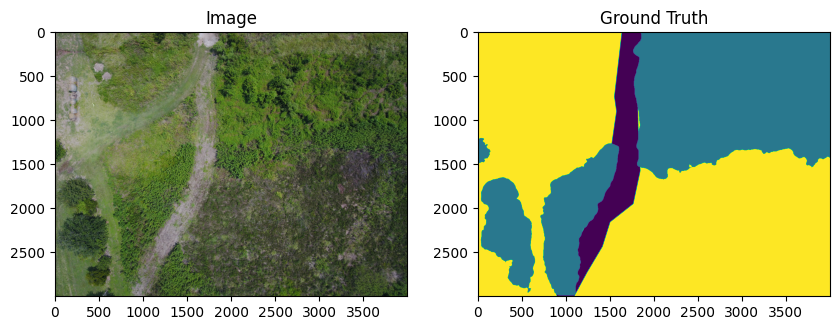

In [9]:
# Check image/mask at index 66 of training set
show_image_mask_pair(train_df, 66)

In [10]:
train_transforms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5)
                    ], is_check_shapes=False)

valid_transforms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE)
    ], is_check_shapes=False)


In [11]:
from torch.utils.data import Dataset

In [12]:
class SegmentationDataset(Dataset):

    def __init__(self, df, augmentations):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        image_path = row['images']
        mask_path = row['masks']

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype('uint8')

        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
        # mask is in two dimensions so expand this to include a single channel: (h, w) -> (h, w, c)
        mask = np.expand_dims(mask, axis=-1)

        if self.augmentations:
            data = self.augmentations(image=image, mask=mask)
            image = data['image']
            mask = data['mask']

        # PyTorch uses (c, h, w) so we transpose from (h, w, c)
        image = np.transpose(image, (2,0,1)).astype(np.float32)
        mask = np.transpose(mask, (2,0,1))

        image = torch.Tensor(image) / 255.0
        mask = torch.Tensor(mask).long()
        # mask = torch.round(torch.Tensor(mask) / 255.0)

        return image, mask

In [27]:
train_ds = SegmentationDataset(train_df, train_transforms)
valid_ds = SegmentationDataset(valid_df, valid_transforms)
# test = SegmentationDataset(test_df, valid_transforms)

# print(f"Number of training samples: {len(test_df)}")
print(f"Number of training samples: {len(train_df)}; number of validation samples: {len(valid_df)}")

Number of training samples: 1410; number of validation samples: 438


In [14]:
from torch.utils.data import DataLoader

In [28]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)
# test_loader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)

torch.Size([3, 256, 256])
torch.float32
<class 'torch.Tensor'>
torch.Size([1, 256, 256])
torch.int64
<class 'torch.Tensor'>
tensor(0.9922)
tensor(0.)
tensor(9)
tensor(6)


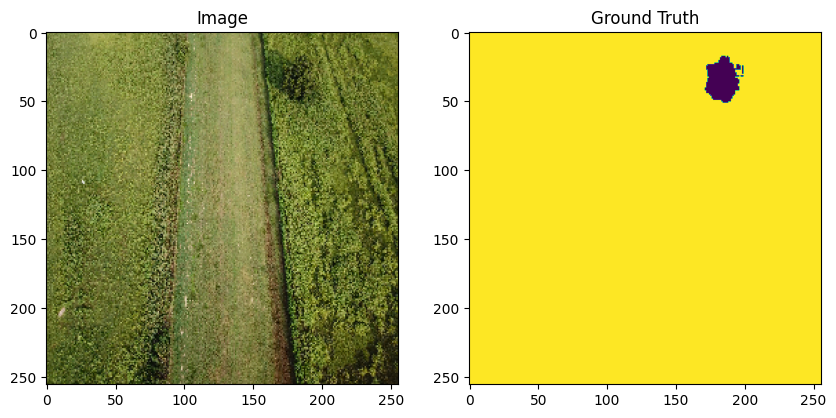

In [29]:
idx = 4
images, labels = next(iter(train_loader))

test_img = images[idx]
test_mask = labels[idx]
print(test_img.shape, test_img.dtype, type(test_img),
      test_mask.shape, test_mask.dtype, type(test_img),
      test_img.max(), test_img.min(),
      test_mask.max(), test_mask.min(),
      sep='\n')

fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].set_title('Image')
ax[0].imshow(test_img.permute(1,2,0))

ax[1].set_title('Ground Truth')
ax[1].imshow(test_mask.permute(1,2,0), cmap=None);

In [30]:
test_mask.unique(), {label: cls for label, cls in class_labels.items() if label in test_mask.unique()}

(tensor([6, 9]), {6: 'Tree', 9: 'Grass'})

In [95]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import JaccardLoss, DiceLoss, SoftCrossEntropyLoss

In [96]:
class SegmentationModel(nn.Module):

    def __init__(self):
        super(SegmentationModel, self).__init__()
        self.arc = smp.PSPNet(
        encoder_name=ENCODER,
        encoder_weights=WEIGHTS,
        in_channels=3,
        classes=len(CLASSES),
        activation=ACTIVATION
        )

    def forward(self, images, masks=None):

        logits = self.arc(images)

        if masks != None:
          # DOUG: NEED TO FIX LOSS2 HERE, ERRORS OUT DURING TRAINING.
            loss1 = JaccardLoss(mode='multiclass')(logits, masks)
            loss2 = SoftCrossEntropyLoss()(logits, masks)
            return logits, loss1 + loss2
            # return logits, loss1

        return logits

In [ ]:
model = SegmentationModel()
model.to(DEVICE)

In [101]:
def train(data_loader, model, optimizer):

    model.train()
    total_loss = 0.0
    for images, masks in tqdm(data_loader):

        images, masks = images.to(DEVICE), masks.to(DEVICE)

        optimizer.zero_grad()

        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

def valid(data_loader, model):

    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for images, masks in tqdm(data_loader):

            images, masks = images.to(DEVICE), masks.to(DEVICE)

            logits, loss = model(images, masks)

            total_loss += loss.item()

    return total_loss / len(data_loader)

In [102]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [103]:
# Set training proportions
EPOCHS = 1
TRAIN_PROP = 0.01
TRAIN_LIMIT = round(TRAIN_PROP * train_df.shape[0])
VALID_LIMIT = round(TRAIN_PROP * valid_df.shape[0])

assert isinstance(TRAIN_LIMIT, int)
assert isinstance(VALID_LIMIT, int)

tr_df = train_df.iloc[:TRAIN_LIMIT].copy()
va_df = valid_df.iloc[:VALID_LIMIT].copy()

print(f"Number of training samples: {len(tr_df)}; number of validation samples: {len(va_df)}")

train_ds = SegmentationDataset(tr_df, train_transforms)
valid_ds = SegmentationDataset(va_df, valid_transforms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)


Number of training samples: 14; number of validation samples: 4


In [ ]:
best_valid_loss = np.Inf

metrics = {
    'train_loss': [],
    'valid_loss': []
}


for i in range(EPOCHS):

    train_loss = train(train_loader, model, optimizer)
    valid_loss = valid(valid_loader, model)
    # Log losses
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), './models/best_model.pt')
        print('MODEL SAVED')
        best_valid_loss = valid_loss

    print(f"Epoch : {i+1} Train_loss: {train_loss} Valid_loss: {valid_loss}")

In [74]:
idx = np.random.choice(len(valid_ds))

model.load_state_dict(torch.load('./models/best_model.pt'))

image, mask = valid_ds[idx]

# We get (c, h, w) out and want to add a single dimension for the batch -> (1, c, h, w)
logits_mask = model(image.to(DEVICE).unsqueeze(0))
# Apply softmax function
m = nn.Softmax(dim=1)
probs = m(logits_mask)
pred_mask = torch.argmax(probs, dim=1).squeeze(1)
pred_mask = (pred_mask.squeeze().cpu().numpy().round())

In [75]:
pred_mask.shape, type(pred_mask), np.unique(pred_mask)

((256, 256), numpy.ndarray, array([6, 9]))

In [76]:
def plot_preds(ds, idx, model):

  image, mask = ds[idx]

  # We get (c, h, w) out and want to add a single dimension for the batch -> (1, c, h, w)
  logits_mask = model(image.to(DEVICE).unsqueeze(0))
  # Apply sigmoid function
  m = nn.Softmax(dim=1)
  probs = m(logits_mask)
  pred_mask = torch.argmax(probs, dim=1).squeeze(1)
  pred_mask = (pred_mask.squeeze().cpu().numpy().round())

  fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,5))

  ax[0].set_title('Image')
  ax[0].imshow(image.permute(1,2,0))

  ax[1].set_title('Ground Truth')
  ax[1].imshow(mask.permute(1,2,0), cmap=None)

  ax[2].set_title('Prediction')
  ax[2].imshow(pred_mask, cmap=None)

  plt.show()

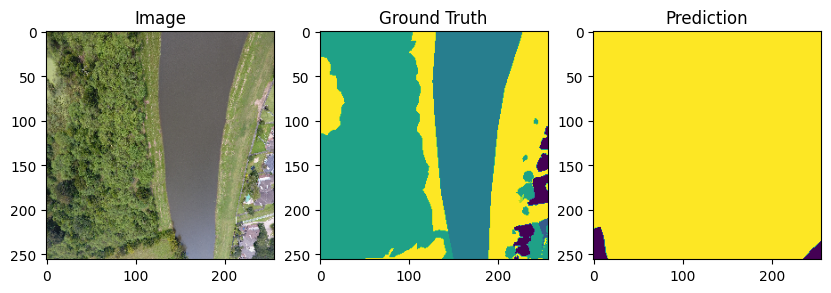

In [77]:
plot_preds(train_ds, 4, model)

In [78]:
metrics

{'train_loss': [0.6612711548805237], 'valid_loss': [0.42429786920547485]}

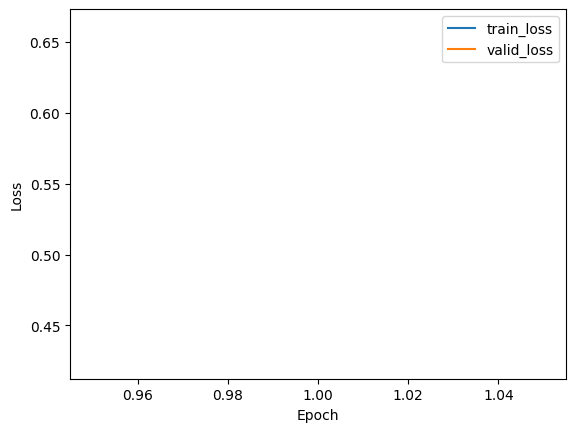

In [79]:

# Extract x-axis values (assuming the lists have the same length)
x_values = list(range(1, EPOCHS+1))

# Plotting
plt.plot(x_values, metrics['train_loss'], label='train_loss')
plt.plot(x_values, metrics['valid_loss'], label='valid_loss')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.title('Plot of List 1 and List 2')

# Adding legend
plt.legend()

# Show the plot
plt.show()